<a href="https://colab.research.google.com/github/KnzMcn/Attempts-At-Learning-CNN/blob/main/cnn_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from google.colab import drive
import zipfile
import os
from PIL import Image

from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix

# Import the dataset

In [3]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# unzip the dataset
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/3rd year/Machine Learning/Learning Evidence/Alzheimers.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
# generate the image datasets
train_set = image_dataset_from_directory('/content/Alzheimers/train',
                                         label_mode = 'int',
                                         color_mode = 'grayscale',
                                         batch_size = 256, 
                                         image_size = (50, 50), 
                                         validation_split = 0.1, 
                                         subset = 'training',
                                         seed = 0, 
                                         shuffle = True)

val_set = image_dataset_from_directory('/content/Alzheimers/train',
                                       label_mode = 'int', 
                                       color_mode = 'grayscale',
                                       batch_size = 256, 
                                       image_size = (50, 50), 
                                       validation_split = 0.1, 
                                       subset = 'validation', 
                                       seed = 0,
                                       shuffle = True)

test_set = image_dataset_from_directory('/content/Alzheimers/test', 
                                        label_mode = 'int', 
                                        color_mode = 'grayscale', 
                                        batch_size = 1279, 
                                        image_size = (50, 50),
                                        shuffle = True)

Found 5121 files belonging to 4 classes.
Using 4609 files for training.
Found 5121 files belonging to 4 classes.
Using 512 files for validation.
Found 1279 files belonging to 4 classes.


In [6]:
# get the class names
class_names = train_set.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

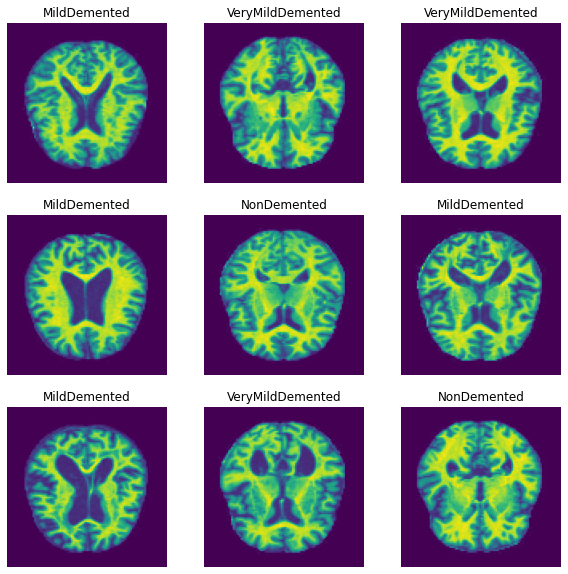

In [7]:
# display the images
plt.figure(figsize = (10, 10))

for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('float32').reshape(50, 50))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [8]:
# retrieve the shapes of the train and test set
for batch, labels in train_set:
  print('Train set shape:', batch.shape, labels.shape)
  break

for batch, labels in test_set:
  test_labels = labels
  print('Test set shape:', batch.shape, labels.shape)
  break

Train set shape: (256, 100, 100, 1) (256,)
Test set shape: (1279, 100, 100, 1) (1279,)


# Preprocessing

In [9]:
# state the number of classes and input shape
num_classes = 4
input_img = (50, 50, 1)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)

In [25]:
# build the layers for augmenting
augmentor = Sequential([layers.Input(shape = input_img),
                        layers.Rescaling(1./255), 
                        layers.RandomFlip('horizontal')])

# Convolutional Neural Network

In [26]:
# build the network
cnn = Sequential([layers.Input(shape = input_img),
                  augmentor,
                  
                  Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'),
                  #Conv2D(128, kernel_size = 3, activation = 'relu', padding = 'same'),
                  MaxPooling2D(2),
                  Dropout(0.75),
                  
                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dropout(0.5),
                  Dense(num_classes, activation = 'softmax')])

In [27]:
# compile the network
cnn.compile(loss = 'sparse_categorical_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy'])
cnn.build(input_img)

In [28]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 100, 100, 1)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 160000)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               20480128  
                                                      

# Train the model

In [29]:
cnn_history = cnn.fit(train_set, 
                      epochs = 130, 
                      verbose = 1,
                      validation_data = val_set)

Epoch 1/130
19/19 [==============================] - 39s 2s/step - loss: 1.9285 - accuracy: 0.4166 - val_loss: 1.0624 - val_accuracy: 0.5059
Epoch 2/130
19/19 [==============================] - 40s 2s/step - loss: 1.0504 - accuracy: 0.5012 - val_loss: 1.0398 - val_accuracy: 0.5059
Epoch 3/130
19/19 [==============================] - 39s 2s/step - loss: 1.0197 - accuracy: 0.5010 - val_loss: 1.0155 - val_accuracy: 0.5059
Epoch 4/130
19/19 [==============================] - 38s 2s/step - loss: 1.0070 - accuracy: 0.5177 - val_loss: 0.9933 - val_accuracy: 0.5156
Epoch 5/130
19/19 [==============================] - 39s 2s/step - loss: 0.9723 - accuracy: 0.5272 - val_loss: 0.9785 - val_accuracy: 0.5410
Epoch 6/130
19/19 [==============================] - 40s 2s/step - loss: 0.9414 - accuracy: 0.5498 - val_loss: 0.9420 - val_accuracy: 0.5430
Epoch 7/130
19/19 [==============================] - 39s 2s/step - loss: 0.9136 - accuracy: 0.5663 - val_loss: 0.9135 - val_accuracy: 0.5488
Epoch 8/130
1

In [30]:
# save the model
cnn.save('cnn.h5')

# Visualization

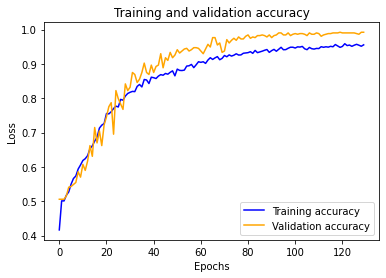

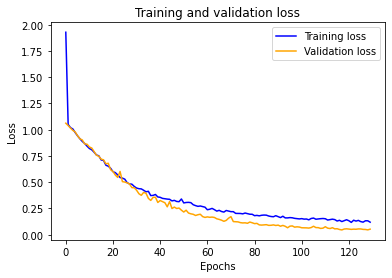

In [31]:
#visualization of the model evaluation
#plot image will change with more epochs
accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs = range(len(accuracy))

#Visualize the accuracy
plt.plot(epochs, accuracy, 'b', c = 'blue', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', c = 'orange', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

#Visualize the loss
plt.plot(epochs, loss, 'b', c = 'blue', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', c = 'orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

In [32]:
test_eval = cnn.evaluate(test_set, verbose = 0)

In [33]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 2.532376289367676
Test accuracy: 0.5691946744918823


# Classification Report

In [34]:
pred_classes = cnn.predict(test_set)

1/1 [==============================] - 7s 7s/step


In [35]:
pred_classes = np.argmax(np.round(pred_classes), axis = 1)

In [36]:
#create a classification report
target_names = ['Class {}'.format(i) for i in range(4)]
print(classification_report(test_labels, pred_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.12      0.02      0.04       179
     Class 1       0.00      0.00      0.00        12
     Class 2       0.53      0.54      0.54       640
     Class 3       0.37      0.49      0.42       448

    accuracy                           0.45      1279
   macro avg       0.26      0.26      0.25      1279
weighted avg       0.41      0.45      0.42      1279



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Confusion Matrix

In [37]:
# create confusion matrix
cm = confusion_matrix(test_labels, pred_classes)

Text(0.5, 1.0, 'Model Accuracy Score: 56.92%')

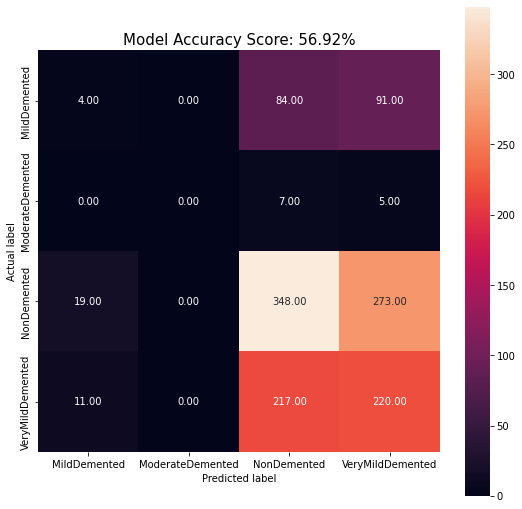

In [38]:
# create a heatmap
plt.figure(figsize=(9, 9))

sns.heatmap(cm, 
            annot = True, 
            fmt = ".2f",
            square = True,
            yticklabels = class_names, 
            xticklabels = class_names)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
all_sample_title = f'Model Accuracy Score: {test_eval[1]:.2%}'
plt.title(all_sample_title, size = 15)